# Questions for NYC data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from shapely.geometry import Point
import dask.dataframe as dd
import dask.distributed
from dask.distributed import Client
%matplotlib inline

import gc

In [2]:
clean_data = pd.read_pickle('data/merged_data.pickle')

In [3]:
clean_data["earnings"].sum()

198929120.0

# Basic Questions

## a. What is the distribution of number of passengers per trip?

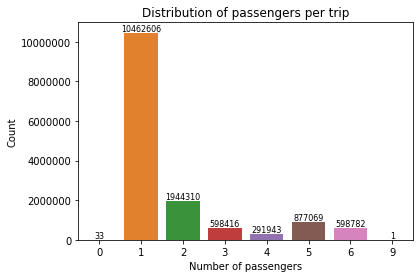

In [4]:
# 
passenger_dist = (clean_data.groupby('passenger_count')
                  .count()
                  .iloc[:,0])
passenger_dist = pd.DataFrame(passenger_dist).rename(columns={"medallion": "counts"})
passenger_dist.reset_index(inplace=True)

passenger_plot = sns.barplot(data=passenger_dist, 
                             x = "passenger_count", 
                             y="counts")
plt.title("Distribution of passengers per trip")
passenger_plot.set_xlabel("Number of passengers")
passenger_plot.set_ylabel("Count")
plt.ticklabel_format(style='plain', axis='y')
passenger_plot.bar_label(passenger_plot.containers[0], 
                         size=8, 
                         fmt="%d")
plt.show()

# Jupyter tends to make a lot of garbage which makes working with large datasets
# eat up ram for no reason. Calling the garbage collector helps!
gc.collect()
None

**Summary**

The vast majority of trips contain one passenger. According to the [NYC Taxi and Limosine Commission](https://www1.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page) website the maximum number of passengers in a standard taxi is 4. After this you need a passenger taxi which can accomodate up to 5 unless you have a child under 7 with you. This explains the dropoff in frequency from 1 to 4 then increase and subsequent dropoff again. The one observation of 9 passengers could either be an error or where each parent has a child on their lap.

## b. What is the distribution of payment_type?

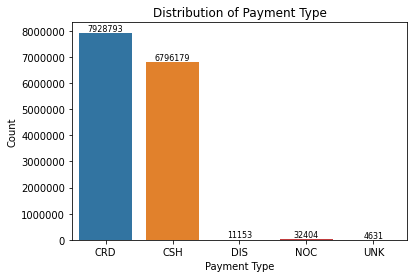

In [5]:
payment_dist = (clean_data.groupby('payment_type')
                .count()
                .iloc[:,0])
payment_dist = pd.DataFrame(payment_dist).rename(columns={"medallion": "counts"})
payment_dist.reset_index(inplace=True)
payment_plot = sns.barplot(data=payment_dist, 
                           x = "payment_type", 
                           y = "counts")
plt.title("Distribution of Payment Type")
payment_plot.set_xlabel("Payment Type")
payment_plot.set_ylabel("Count")
plt.ticklabel_format(style='plain', 
                     axis='y')
payment_plot.bar_label(payment_plot.containers[0],
                       size=8,
                       fmt="%d")
plt.show()
gc.collect()
None

**Summary**

The majority of payment times are Credit and Cash. Dispute, No charge, Unknown transactions are infrequent enough they could be ignored. No charge is most likely due to negotiated fares.  

## c. What is the distribution of fare amount?

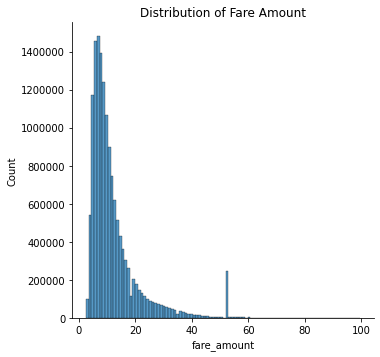

In [6]:
fare_plot = sns.displot(data=clean_data[clean_data.fare_amount<100],
                        x="fare_amount",
                        kind="hist",
                        bins=100)
plt.ticklabel_format(style='plain', 
                     axis='y')
plt.title("Distribution of Fare Amount")
gc.collect()
None

**Summary**

The fares shown in the plot were restricted to those less than 100 to highlight the patterns in the distribution (fares higher than 100 are not frequent). Fares start at 2.5 USD (the minimum for NYC taxis). The bulk of the density lies between 5-20 USD with a large peak around 52 USD (The flat rate between JFK and Manhattan).

## d. What is the distribution of tip amount?

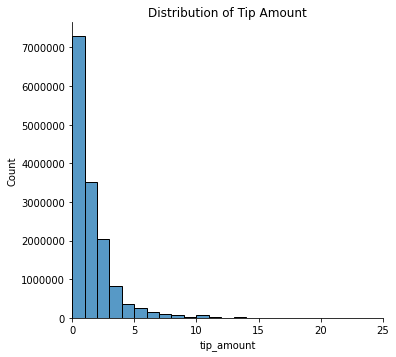

In [7]:
tip_plot = sns.displot(data=clean_data[clean_data.tip_amount<25],
                       x="tip_amount",
                       kind="hist",
                       bins=25)
plt.ticklabel_format(style='plain', 
                     axis='y')
tip_plot.set(xlim=(0, 25))
plt.title("Distribution of Tip Amount")
plt.show()
gc.collect()
None

**Summary**

The most common tip is 0 USD, there is a sharp decline as the tipping amount increases and rarely is anyone tipped above 10 USD. Looking above the $25 tips we see some high frequencies around 30, 50 and 100 USD, however the probability of these occuring is very low. It would be interesting to deepdive on how to increase your chances of a unicorn tip though.

## e. What is the distribution of total amount?

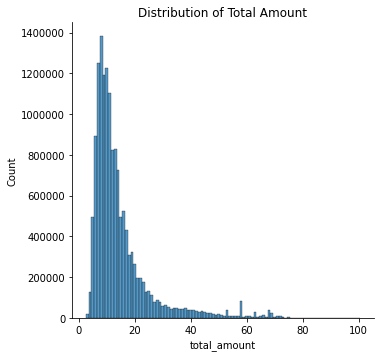

In [8]:
total_plot = sns.displot(data=clean_data[clean_data["total_amount"] < 100],
            x="total_amount",
            kind="hist",
            binwidth=1)
plt.ticklabel_format(style='plain', 
                     axis='y')
plt.title("Distribution of Total Amount")
plt.show()
gc.collect()
None

**Summary**

The total distribution is very similar to the fare distribution however it is a little right shifted and wider as we include tips, tax and tolls.

## f. What are top 5 busiest hours of the day?

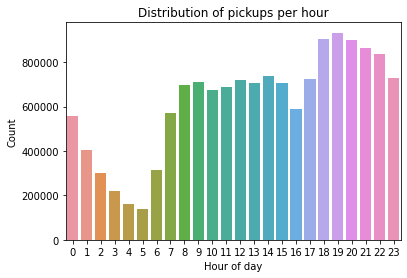

In [9]:
# Count the number of observations that belong to each value of 
# passenger count. Storing as a dataframe for plotting.
def get_distribution(df, group):
    """Count the number of observations that belong to each value of 
    passenger count. Storing as a dataframe for plotting.
    
    Params: 
        df: pandas.core.frame.DataFrame
        group: str
    Returns:
        pandas.core.frame.DataFrame
    """
    df = pd.DataFrame(df.groupby(group)
                      .count()
                      .iloc[:,0])
    df = (df.rename(columns={df.columns[0]: "counts"})
          .reset_index())
    return df

time_dist = get_distribution(clean_data, 
                             clean_data.pickup_datetime.dt.hour)
time_plot = sns.barplot(data=time_dist, 
                        x="pickup_datetime", 
                        y="counts")
plt.title("Distribution of pickups per hour")
time_plot.set_xlabel("Hour of day")
time_plot.set_ylabel("Count")
plt.ticklabel_format(style='plain', axis='y')
passenger_plot.bar_label(time_plot.containers[0], 
                         size=8, 
                         fmt="%d")
plt.show()
gc.collect()
None

**Summary**

The highest number of pickups occurs between 6pm and 10pm.

## g. What are the top 10 busiest locations of the city?

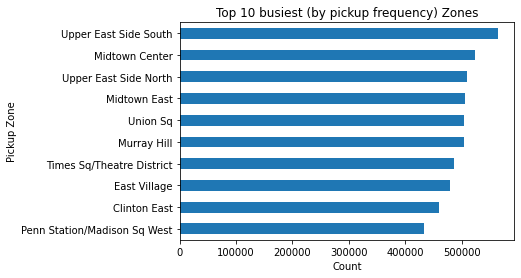

In [10]:
# Count the number of times a pickup occured in a zone, sort by the highest counts
top_10_pickup_zones = (clean_data.groupby("pickup_zone")
                    .count()
                    .sort_values(clean_data.columns[0],
                                 ascending=False)
                    .loc[:,clean_data.columns[0]])
top_10_pickup_zones.name = "count"
top_10_pickup_zones_ax = (top_10_pickup_zones
                     .head(10)
                     .sort_values(ascending=True)
                     .plot(x="zone", 
                           y="count", 
                           kind="barh"))
top_10_pickup_zones_ax.set_xlabel("Count")
top_10_pickup_zones_ax.set_ylabel("Pickup Zone")
top_10_pickup_zones_ax.set_title("Top 10 busiest (by pickup frequency) Zones")
gc.collect()
None

**Summary**

The busiest zones by frequency of pickup are all in Manhattan. This makes sense as it has the highest population density of the 5 boroughs in New York.

## h. Which trip has the highest standard deviation of travel time?

In [11]:
trip_stddev = (clean_data
               .groupby("trip")
               .std()
               .sort_values("trip_time_in_secs", 
                            ascending=False)
               .head(1))


**Summary**

In [12]:
print("Trip with the highest standard deviation of travel time:", trip_stddev.index.values[0])
print("stddev: ", "{}".format(round(trip_stddev.trip_time_in_secs.values[0])))

Trip with the highest standard deviation of travel time: Whitestone to JFK Airport
stddev:  5599


## i. Which trip has most consistent fares?

In [13]:
# For each trip, how many times has the trip been taken and what is the sd of the fare?
trip_fare_summary = (clean_data[["trip", "fare_amount"]]
                     .groupby("trip")
                     .agg(["count", "std"]))
# Of the fares which have 0 sd which one has the highest count?
(trip_fare_summary[trip_fare_summary["fare_amount"]["std"] == 0]
 .sort_values(("fare_amount", "count"), 
              ascending=False)
 .iloc[0])

fare_amount  count    93.0
             std       0.0
Name: Hamilton Heights to JFK Airport, dtype: float64

**Summary**

The lowest standard deviation trips in the dataset have an sd of 0. If we look at the highest count trip (the one we can be most confident about) we get Hamilton Heights to JFK Airport. 

# Open Questions

In [14]:
# Resetting all variables to free up memory

%reset -f

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from scipy.stats import skewtest

import gc
gc.collect()

clean_data = pd.read_pickle('data/merged_data.pickle')

## a. In what trips can you confidently use respective means as measures of central tendency to estimate fare, time taken, etc.

### Sample Size

$\text{Sample Size} = \left ( \frac{Z_{\frac{\alpha}{2}} \sigma }{\text{Margin of error}} \right )^2$

In [15]:
fare_std = clean_data.fare_amount.std()
q = 1.96 # 95% conf interval
margin_of_error = 1
min_sample_size = ((q * fare_std)/ margin_of_error)**2
round(min_sample_size)

338

**Summary**

Using power analysis we found a confidence interval of 95% on $\hat{y} \pm 1$ for fare_amount can be achieved with a sample size of 338. The choice for the margin of error was chosen completely arbitrarily and if I were to be doing this in a business setting more discussion with business leaders would get us different numbers depending on what they want.

### Skew

In [16]:
%%time

# How many times is each trip taken?
grouped_trip = clean_data.groupby("trip")
grouped_trip = (grouped_trip["trip"]
                .agg(count="count")
                .sort_values(by="count")
                .reset_index())
# The subset of trips which occurred more than 338 times
clt_subset = grouped_trip[grouped_trip["count"] > min_sample_size]

"""
For each trip, calculate the skewness of each value, return those with low skew
dict = {
        "fare_amount":[],
        "trip_time_in_secs":[]
    }
"""

vars_of_interest = ["fare_amount", "trip_time_in_secs"]
result = 0
sig = 0.05
min_n = min_sample_size
trip_count_gt_30 = clean_data.iloc[clt_subset.index]["trip"]
low_skew_trips = {var:[] for var in vars_of_interest}
for trip in trip_count_gt_30:
    for var in vars_of_interest:
        skew_result = (0,0)
        test = clean_data[clean_data["trip"]==trip][var]
        if len(test) > min_n: 
            skew_result = skewtest(test) 
        if skew_result[1] > sig:
            # if we get a large pvalue for the test, we can use the mean!
            low_skew_trips[var].append(trip)

CPU times: user 1min 39s, sys: 194 ms, total: 1min 39s
Wall time: 1min 39s


In [17]:
len(low_skew_trips["fare_amount"])

34

**Summary**

One of the other factors that can affect the choice of median over mean is skew. This script shows that 34 trips have low skew and be best represented by the mean. In hindsight this is too harsh and computationally expensive to use, but I already wrote the code so I'll leave it in.

## b. Can we build a model to predict fare and tip amount given pick up and drop off coordinates, time of day and week?

In [18]:
# Resetting all variables to free up memory

%reset -f

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import datetime as dt
import calendar
pd.options.mode.chained_assignment = None

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



import gc
gc.collect()

clean_data = pd.read_pickle('data/merged_data.pickle')

In [19]:
%%time

# Predictor variables specified in the question
X = clean_data[
    [
        'pickup_hour',
        'dropoff_hour',
        'pickup_day',
        'pickup_longitude', 
        'pickup_latitude', 
        'dropoff_longitude',
        'dropoff_latitude'
    ]
]
"""
Pickup and dropoff coordinates already exist in a useable state
However we need to turn the datetime formats into hour of the day
and day of the week as per the question
"""

# LinearRegression() cant take the category dtype so we convert it to dummy variables
X = pd.get_dummies(X)

y = clean_data['earnings']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25,
                                                    random_state=2022)

CPU times: user 5.04 s, sys: 311 ms, total: 5.35 s
Wall time: 5.35 s


### The base model

In [20]:
"""
The base prediction is the mean fare/tip amount recieved
"""

base_prediction = np.repeat(y_train
                            .mean(), 
                            len(y_test))
base_rmse = np.sqrt(mean_squared_error(base_prediction, 
                                       y_test))
round(base_rmse, 2)

10.59

### Linear Regression

In [21]:
%%time
reg = LinearRegression().fit(X_train, y_train)
reg_pred = reg.predict(X_test)
reg_rmse = np.sqrt(mean_squared_error(y_test, reg_pred))

round(reg_rmse, 2)

CPU times: user 5.12 s, sys: 911 ms, total: 6.03 s
Wall time: 2.84 s


8.66

In [22]:
{y:x for x,y in zip(list(reg.coef_), list(X.columns))} # Show the coefficients for the LM

{'pickup_hour': -0.008643277,
 'dropoff_hour': 0.0052344967,
 'pickup_longitude': 117.07359,
 'pickup_latitude': -61.353916,
 'dropoff_longitude': 86.15669,
 'dropoff_latitude': -71.03567,
 'pickup_day_Friday': 0.14483428,
 'pickup_day_Monday': -0.25071594,
 'pickup_day_Saturday': -0.24631372,
 'pickup_day_Sunday': 0.060371257,
 'pickup_day_Thursday': 0.33026186,
 'pickup_day_Tuesday': -0.112995036,
 'pickup_day_Wednesday': 0.074558884}

### Random Forest

In [23]:
%%time
rf = RandomForestRegressor(n_estimators=5,
                           min_samples_split = 2000,
                           min_samples_leaf = 1000,
                           n_jobs = -1,
                           max_depth = 10,
                           random_state=2022).fit(X_train,y_train)
rf_pred = rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

round(rf_rmse, 2)

CPU times: user 6min 44s, sys: 997 ms, total: 6min 45s
Wall time: 2min 17s


5.23

**Summary**

Yes we can build models out of these variables. The base prediction ($y_{i}=\hat{y}$) RMSE is 10.59. 

To improve on this linear model was developed and random forest model with pickup/dropoff longitudes and latitudes, pickup/dropoff hours and day of the week as variables.

The linear model improved upon the base with a RMSE of 8.66 and the random forest was the best model at 5.23. 

The coefficients from the linear model show large effects from longitude and latitude change, Thursday is the best day of the week to achieve a high fare and Monday is the worst. Later pickup times correlate to lower fares however later dropoff times correlate to higher fares. 

## c. If you were a taxi owner, how would you maximize your earnings in a day?

### What are the best day/time combinations to maximize fares? 

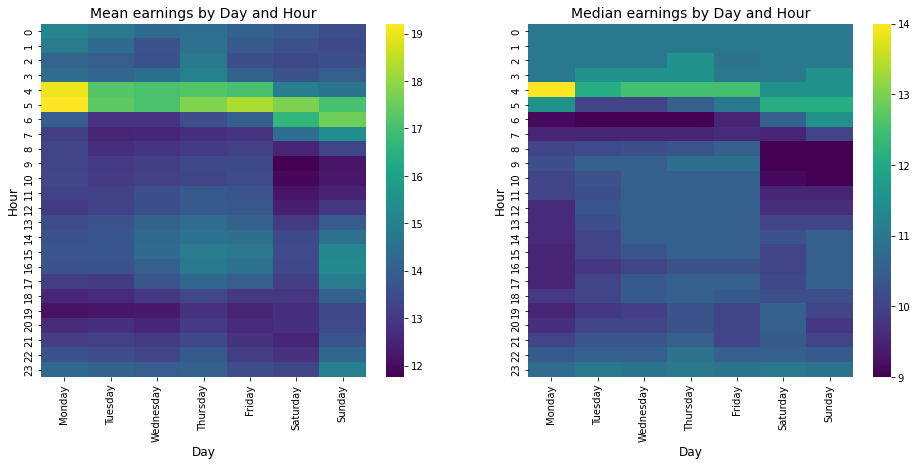

In [24]:
# What is the average earnings for each day and time in a week?
time_of_day_earnings_mean = clean_data.groupby(["pickup_day","pickup_hour"])["earnings"].mean().reset_index()
time_of_day_earnings_mean = pd.pivot_table(time_of_day_earnings_mean, 
                                      values="earnings",
                                      index=["pickup_hour"], 
                                      columns=["pickup_day"], 
                                      fill_value=0)

time_of_day_earnings_median = clean_data.groupby(["pickup_day","pickup_hour"])["earnings"].median().reset_index()
time_of_day_earnings_median = pd.pivot_table(time_of_day_earnings_median, 
                                      values="earnings",
                                      index=["pickup_hour"], 
                                      columns=["pickup_day"], 
                                      fill_value=0)
# reorder days of week for the plot
days_of_week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
time_of_day_earnings_mean = time_of_day_earnings_mean[days_of_week]
time_of_day_earnings_median = time_of_day_earnings_median[days_of_week]

fig, ax = plt.subplots(1,2,figsize=(16,6.5))
tode_plot_mean = sns.heatmap(time_of_day_earnings_mean, ax=ax[0], cmap="viridis", annot=False)
tode_plot_median = sns.heatmap(time_of_day_earnings_median, ax=ax[1], cmap="viridis")
ax[0].set_xlabel('Day', fontsize=12)
ax[0].set_ylabel('Hour', fontsize=12)
ax[0].set_title('Mean earnings by Day and Hour', fontsize=14)
ax[1].set_xlabel('Day', fontsize=12)
ax[1].set_ylabel('Hour', fontsize=12)
ax[1].set_title('Median earnings by Day and Hour', fontsize=14)
plt.show()
gc.collect()
None

**Summary**

The heat maps show starting early in the morning around 4-5am is most likely to get you a high earnings (fare + tip). After this there is a low earnings period between 6-8am which might be a good time to take a break. After 8am things pick up presumably as people try to get to work and move around the city, remaining steadily constant until the evening around 6-8pm when another earnings dropoff occurs. Monday 4am peaks at a mean earnings of 19 USD and median of 14 USD meaning it would be farely robust to start work at this timeslot.

Looking at the days of the week, Saturday and Sunday morning between 8am-12pm look to be the worst times to work in terms of earnings. Thursday has the most moderately high fares throughout the entire day.

### Earnings rate

In [25]:
# TODO: Write as a function
fare_std = clean_data.fare_amount.std()
q = 1.96 # 95% conf interval
margin_of_error = 1
min_sample_size = ((q * fare_std)/ margin_of_error)**2
round(min_sample_size)

sub = clean_data[clean_data["trip_time_in_secs"] > 0][["trip", "earnings", "trip_time_in_secs"]].groupby(["trip"]).agg(["count", "mean"]).reset_index()
sub = sub[sub["earnings"]["count"] > min_sample_size]
sub = sub.sort_values(by=("earnings", "mean"), ascending=False)
sub.loc[:, ("earnings_per_second", "mean")] = sub["earnings"]["mean"] / sub["trip_time_in_secs"]["mean"] 
sub.sort_values(by=("earnings_per_second", "mean"), ascending=False)
no_airport_sub = sub[~sub['trip'].str.contains("Airport")].sort_values(by=("earnings_per_second", "mean"), 
                                                                       ascending=False).head(10)
no_airport_sub = pd.merge(no_airport_sub["trip"].to_frame(), 
                          no_airport_sub["earnings_per_second"], 
                          left_index=True, right_index=True).rename(columns={"mean":"mean_earning_per_second"})
no_airport_sub

,trip,mean_earning_per_second
25439,Washington Heights North to Washington Heights...,0.039269
20664,Saint Michaels Cemetery/Woodside to Saint Mich...,0.038810
14769,Long Island City/Hunters Point to Murray Hill,0.034773
10036,Gowanus to Gowanus,0.030557
22090,Stuy Town/Peter Cooper Village to Financial Di...,0.029094
8119,Financial District North to Financial District...,0.029068
17736,Mott Haven/Port Morris to Mott Haven/Port Morris,0.028916
11167,Hamilton Heights to Hamilton Heights,0.028683
13023,Kips Bay to Financial District South,0.027801
4665,Clinton West to Washington Heights South,0.027757


**Summary**

The highest earning rates are in Manhattan and Brooklyn and tend to be shorter trips (within zone). 

In [26]:
airport_sub = sub[sub['trip'].str.contains("Airport")].sort_values(by=("earnings_per_second", "mean"), ascending=False).head(10)
airport_sub = pd.merge(airport_sub["trip"].to_frame(), airport_sub["earnings_per_second"], left_index=True, right_index=True).rename(columns={"mean":"mean_earning_per_second"})
airport_sub

,trip,mean_earning_per_second
18164,Newark Airport to Newark Airport,1.223317
12115,JFK Airport to JFK Airport,0.063568
23423,TriBeCa/Civic Center to Newark Airport,0.041063
26203,West Village to Newark Airport,0.041003
6131,East Chelsea to Newark Airport,0.040166
8806,Flatiron to Newark Airport,0.039803
19126,Penn Station/Madison Sq West to Newark Airport,0.039619
4189,Clinton East to Newark Airport,0.039583
25133,Upper West Side South to Newark Airport,0.038038
16089,Meatpacking/West Village West to Newark Airport,0.037711


The highest fare earnings are to and from Newark and JFK airports. The data for these trips is a little unreliable because the rate code 5 specifies that the driver has negotiated the fare (and as a result we get no information on pickup/dropoff points, distance traveled or time taken). Looking at the website for [Newark Airport](https://www.newarkairport.com/to-from-airport/taxi-car-and-van-service) we see a price list which shows trips from the airport exceeding 80 USD so the earnings values can be assumed valid. 


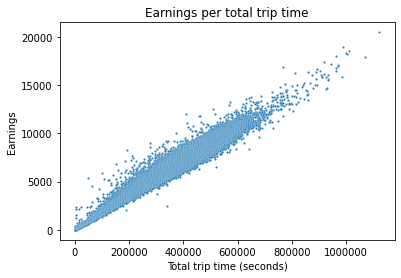

In [27]:
taxi_earnings = clean_data.groupby(["hack_license"]).sum()[["earnings", "trip_time_in_secs"]].sort_values(by="earnings", ascending=False)
taxi_earnings = taxi_earnings.reset_index()

taxi_earnings_plot = sns.scatterplot(data=taxi_earnings,
                                     x="trip_time_in_secs", 
                                     y="earnings",
                                     s=5)
plt.title("Earnings per total trip time")
taxi_earnings_plot.set_xlabel("Total trip time (seconds)")
taxi_earnings_plot.set_ylabel("Earnings")
plt.ticklabel_format(style='plain', 
                     axis='x')

plt.show()
gc.collect()
None

**Summary**

There is a direct correlation between each drivers earnings and their total time spent driving customers around. The highest earner is also the person with the most hours worked. Given more time I would like to tease apart the differences between those who work similar hours.

### Who is our Max earner?

In [28]:
hack_trips = clean_data.groupby(["hack_license"]).count()
hack_trips = hack_trips["medallion"].reset_index()
hack_earnings = pd.merge(taxi_earnings, hack_trips).rename(columns={"medallion": "n_trips"})
hack_earnings = hack_earnings[hack_earnings["n_trips"] > 30]
hack_earnings["rate"] = hack_earnings["earnings"] / hack_earnings["trip_time_in_secs"]
max_earner = hack_earnings[hack_earnings.earnings > hack_earnings.earnings.median()].sort_values("earnings", ascending=False).iloc[0]
max_earner

hack_license         D85749E8852FCC66A990E40605607B2F
earnings                                 20481.410156
trip_time_in_secs                           1123200.0
n_trips                                          1603
rate                                         0.018235
Name: 0, dtype: object

Our Max earner worked for 312 hours (80 hour weeks) and pulled in $20481 for the month.

In [29]:
max_taxi = clean_data[clean_data["hack_license"] == max_earner['hack_license']].drop(["medallion", 
                                                                                   "hack_license", 
                                                                                   "vendor_id" ,
                                                                                   "surcharge",
                                                                                   "mta_tax",
                                                                                  "store_and_fwd_flag",
                                                                                  "tolls_amount",
                                                                                  "total_amount","payment_type"], axis=1)
max_pickups = max_taxi.groupby("pickup_zone").count()["rate_code"][max_taxi.groupby("pickup_zone").count()["rate_code"].sort_values() > 0]
max_pickups.name = "count"


In [30]:
from bokeh.io import output_notebook
from bokeh.models import GeoJSONDataSource, HoverTool, CategoricalColorMapper, LinearColorMapper
from bokeh.plotting import figure, show
from bokeh.palettes import Category10
output_notebook()

from bokeh.palettes import viridis
from bokeh.models import ColorBar, LogColorMapper
figures = {}

zones = gpd.read_file("data/shapefile/taxi_zones.shp")
zones = zones[['zone','LocationID', 'geometry', 'borough']]
zones = zones.to_crs(crs=4326)

joined = gpd.GeoDataFrame(pd.merge(max_pickups.to_frame(), zones, left_on='pickup_zone', right_on='zone'))

geo_source = GeoJSONDataSource(geojson=joined.to_json())

color_mapper = LogColorMapper(viridis(256))

fig = figure(title="Max's Pick Ups")
fig.patches(xs='xs', ys='ys', alpha=0.9, source=geo_source, 
            color={'field': 'count', 'transform': color_mapper}, 
            line_width=1, line_alpha=0.5, line_color='black')

hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=('<div><b>Borough</b>: @borough</div>'
              '<div><b>Zone</b>: @zone</div>'
              '<div><b>Pickups</b>: @count</div>')
)
fig.add_tools(hover)

color_bar = ColorBar(color_mapper=color_mapper, 
                     location=(0, 0), 
                     label_standoff=12)
fig.add_layout(color_bar, 'right')

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

figures['ride-counts'] = fig

show(fig)

Loading BokehJS ...

In [31]:
zones = gpd.read_file("data/shapefile/taxi_zones.shp")
zones = zones[['zone','LocationID', 'geometry', 'borough']]
zones = zones.to_crs(crs=4326)

max_dropoffs = max_taxi.groupby("dropoff_zone").count()["rate_code"][max_taxi.groupby("dropoff_zone").count()["rate_code"].sort_values() > 0]
max_dropoffs.name = "count"

joined = gpd.GeoDataFrame(pd.merge(max_dropoffs.to_frame(), zones, left_on='dropoff_zone', right_on='zone'))

geo_source = GeoJSONDataSource(geojson=joined.to_json())

color_mapper = LogColorMapper(viridis(256))

fig = figure(title="Max's Drop Offs")
fig.patches(xs='xs', ys='ys', alpha=0.9, source=geo_source, 
            color={'field': 'count', 'transform': color_mapper}, 
            line_width=1, line_alpha=0.5, line_color='black')

hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=('<div><b>Borough</b>: @borough</div>'
              '<div><b>Zone</b>: @zone</div>'
              '<div><b>Dropoffs</b>: @count</div>')
)
fig.add_tools(hover)

color_bar = ColorBar(color_mapper=color_mapper, 
                     location=(0, 0), 
                     label_standoff=12)
fig.add_layout(color_bar, 'right')

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

figures['ride-counts'] = fig

show(fig)

Looking at our top earner Max, we see a focus on the Manhattan Borough with most pickups and dropoffs around the Upper West and Upper East sides respectively. Max also makes relatively frequent trips to LaGuardia and JFK Airports. He tends to have more luck picking up return trips from LaGuardia.

In order to maximize my earnings I would follow Max's strategy of putting in a large amount of hours and focusing on trips in Manhattan around 10 minutes long. With the occasional trip to the Airports when you can get them. 

## d. If you were a taxi owner, how would you minimize your work time while retaining the average wages earned by a typical taxi in the dataset?

### Who worked at the best rate?

In [32]:
hack_trips = clean_data.groupby(["hack_license"]).count()
hack_trips = hack_trips["medallion"].reset_index()
hack_earnings = pd.merge(taxi_earnings, hack_trips).rename(columns={"medallion": "n_trips"})
hack_earnings = hack_earnings[hack_earnings["n_trips"] > 30]
hack_earnings["rate"] = hack_earnings["earnings"] / hack_earnings["trip_time_in_secs"]
min_earner = hack_earnings[hack_earnings.earnings > hack_earnings.earnings.median()].sort_values("rate", ascending=False).iloc[0]
min_earner

hack_license         A5812ADC65B3B42CC23C9A9D61942A6F
earnings                                  6821.669922
trip_time_in_secs                            150474.0
n_trips                                           171
rate                                         0.045335
Name: 14449, dtype: object

**Summary**

This driver was selected as they earned at least the median income for the month but put in the least amount of time. They earned 6821 USD working 41 hours or 10 hours a week.

In [33]:
min_taxi = clean_data[clean_data["hack_license"] == min_earner["hack_license"]].drop(["medallion", 
                                                                                   "hack_license", 
                                                                                   "vendor_id" ,
                                                                                   "surcharge",
                                                                                   "mta_tax",
                                                                                  "store_and_fwd_flag",
                                                                                  "tolls_amount",
                                                                                  "total_amount","payment_type"], axis=1)
min_pickups = min_taxi.groupby("pickup_zone").count()["rate_code"][min_taxi.groupby("pickup_zone").count()["rate_code"].sort_values() > 0]
min_pickups.name = "count"

In [34]:
zones = gpd.read_file("data/shapefile/taxi_zones.shp")
zones = zones[['zone','LocationID', 'geometry', 'borough']]
zones = zones.to_crs(crs=4326)

joined = gpd.GeoDataFrame(pd.merge(min_pickups.to_frame(), zones, left_on='pickup_zone', right_on='zone'))

geo_source = GeoJSONDataSource(geojson=joined.to_json())

color_mapper = LogColorMapper(viridis(256))

fig = figure(title="Min's Pick Ups")
fig.patches(xs='xs', ys='ys', alpha=0.9, source=geo_source, 
            color={'field': 'count', 'transform': color_mapper}, 
            line_width=1, line_alpha=0.5, line_color='black')

hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=('<div><b>Borough</b>: @borough</div>'
              '<div><b>Zone</b>: @zone</div>'
              '<div><b>Pickups</b>: @count</div>')
)
fig.add_tools(hover)

color_bar = ColorBar(color_mapper=color_mapper, 
                     location=(0, 0), 
                     label_standoff=12)
fig.add_layout(color_bar, 'right')

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

figures['ride-counts'] = fig

show(fig)

In [35]:
min_dropoffs = min_taxi.groupby("dropoff_zone").count()["rate_code"][min_taxi.groupby("dropoff_zone").count()["rate_code"].sort_values() > 0]
min_dropoffs.name = "count"

joined = gpd.GeoDataFrame(pd.merge(min_dropoffs.to_frame(), zones, left_on='dropoff_zone', right_on='zone'))

geo_source = GeoJSONDataSource(geojson=joined.to_json())

color_mapper = LogColorMapper(viridis(256))

fig = figure(title="Min's Drop Offs")
fig.patches(xs='xs', ys='ys', alpha=0.9, source=geo_source, 
            color={'field': 'count', 'transform': color_mapper}, 
            line_width=1, line_alpha=0.5, line_color='black')

hover = HoverTool(
    point_policy='follow_mouse',
    tooltips=('<div><b>Borough</b>: @borough</div>'
              '<div><b>Zone</b>: @zone</div>'
              '<div><b>Pickups</b>: @count</div>')
)
fig.add_tools(hover)

color_bar = ColorBar(color_mapper=color_mapper, 
                     location=(0, 0), 
                     label_standoff=12)
fig.add_layout(color_bar, 'right')

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

figures['ride-counts'] = fig

show(fig)

**Summary**

This driver accomplishes her high rate of income by focusing on trips to and from JFK airport. 

Using this drivers strategy of focusing on JFK airport and the plot showing starting at 4am is a high earning time, I would start at 4am daily and look for trips to and from JFK airport.

## e. If you run a taxi company with 10 taxis, how would you maximize your earnings?

The simplest approach would be to hire the enough drivers to keep the taxis running for the majority of the week, maybe excluding the lowest earnings times like Saturday and Sunday morning. The top 10 earners are all putting in 60+ hour weeks, so uptime is money. 

Starting at 4am is a must to capitalize on the early morning trips to the airports. With the majority of drivers shifting to Manhattan after their first trips back from the Airport.

The times that are busiest are around the early morning rush at 8am, midday to 3pm and between 6pm and 10pm. I would have the majority of drivers spend this time in Manhattan, with still a few drivers solely focusing on JFK and LaGuardia for the high earnings rate trips.